In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ensemble_model.preprocesser as preprocesser 
import ensemble_model.combined_model as cm 
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
# train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
# test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
val = pd.read_csv('./datasets/val.csv')

train.reset_index(inplace=True)
test.reset_index(inplace=True)
val.reset_index(inplace=True)

In [3]:
# df['command'] = df['diff'].apply(lambda x : extract_lines(find_longest_list([y.changes for y in whatthepatch.parse_patch(x)])))
# extracted_cols = df['diff'].str.extract(r'^diff --git (?P<source>[^\t\n]+) (?P<target>[^\t\n]+)')
# whatthepatch.apply_diff(diff, lao)

In [4]:
# len(df_dataset)

In [5]:
# df_dataset[0]

In [6]:
# Load BERT and CodeBERT models and tokenizers
bert_model = BertModel.from_pretrained('./models/bert-base-cased')
bert_tokenizer = BertTokenizer.from_pretrained('./models/bert-base-cased')

codebert_model = RobertaModel.from_pretrained('./models/codebert-base')
codebert_tokenizer = RobertaTokenizer.from_pretrained('./models/codebert-base')

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
train

,index,Unnamed: 0,label,message,diff
0,0,1385,0,Fix initialization of byte order in Creative V...,diff --git a/ChangeLog b/ChangeLog\nindex 11e7...
1,1,654,0,Fix stupid path error,diff --git a/captcha/simple-php-captcha.php b/...
2,2,1201,1,Fixed errors being dumped to the console when ...,diff --git a/examples/FilterShowcase/FilterSho...
3,3,2413,0,Update runtime files.,diff --git a/.github/CODEOWNERS b/.github/CODE...
4,4,4237,1,Add additional configuration options to the DI...,diff --git a/java/org/apache/catalina/authenti...
...,...,...,...,...,...
7073,7073,5734,0,Fix getPicon,diff --git a/plugin/controllers/models/service...
7074,7074,5191,0,HBASE-25361 [Flakey Tests] branch-2 TestMetaRe...,diff --git a/hbase-server/src/test/java/org/ap...
7075,7075,5390,0,Update the meaning of low-hanging-fruit\n\nDur...,diff --git a/doc/source/contributor/how-can-i-...
7076,7076,860,0,QPID-8368: [Broker-J] Make GrayLogger implemen...,diff --git a/broker-plugins/graylog-logging-lo...


In [8]:
# Create Datasets and DataLoaders
train_dataset = preprocesser.SentencePairDataset(train, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
val_dataset = preprocesser.SentencePairDataset(val, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
test_dataset = preprocesser.SentencePairDataset(test, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



base_model1 = cm.BaseModel(bert_model,bert_tokenizer)
base_model2 = cm.BaseModel(codebert_model,codebert_tokenizer)

# Create stacking model
combined_model = cm.CombinedModel(base_model1, base_model2)
# Train the model
combined_model.trainer(train_loader, val_loader,num_epochs=10, patience=3)

/root/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10 Loss: 0.4221: 100%|██████████| 222/222 [10:07<00:00,  1.14s/batch]

=============================train========================
=============================eval========================


Epoch 1/10 Loss: 0.4221: 100%|██████████| 222/222 [11:57<00:00,  3.23s/batch]


Validation Accuracy: 0.8714568226763348
Precision: 0.8707716929484446
Recall: 0.8714568226763348
F1-Score: 0.8704987211750062
Epoch 1/10, Validation Accuracy: 0.8714568226763348
当前best acc 0.8714568226763348


Epoch 2/10 Loss: 0.2253: 100%|██████████| 222/222 [09:03<00:00,  1.23batch/s]

=============================train========================
=============================eval========================


Epoch 2/10 Loss: 0.2253: 100%|██████████| 222/222 [10:39<00:00,  2.88s/batch]


Validation Accuracy: 0.8793671720500988
Precision: 0.8817929959961804
Recall: 0.8793671720500988
F1-Score: 0.880043488662585
Epoch 2/10, Validation Accuracy: 0.8793671720500988
当前best acc 0.8793671720500988


Epoch 3/10 Loss: 0.1407: 100%|██████████| 222/222 [08:58<00:00,  1.28batch/s]

=============================train========================
=============================eval========================


Epoch 3/10 Loss: 0.1407: 100%|██████████| 222/222 [10:38<00:00,  2.87s/batch]


Validation Accuracy: 0.8892551087673038
Precision: 0.8888845982471323
Recall: 0.8892551087673038
F1-Score: 0.8884061023809328
Epoch 3/10, Validation Accuracy: 0.8892551087673038
当前best acc 0.8892551087673038


Epoch 4/10 Loss: 0.0944: 100%|██████████| 222/222 [08:45<00:00,  1.19batch/s]

=============================train========================
=============================eval========================


Epoch 4/10 Loss: 0.0944: 100%|██████████| 222/222 [10:25<00:00,  2.82s/batch]


Validation Accuracy: 0.8998022412656559
Precision: 0.8994171228980704
Recall: 0.8998022412656559
F1-Score: 0.8992826682481855
Epoch 4/10, Validation Accuracy: 0.8998022412656559
当前best acc 0.8998022412656559


Epoch 5/10 Loss: 0.0741: 100%|██████████| 222/222 [08:59<00:00,  1.10batch/s]

=============================train========================
=============================eval========================


Epoch 5/10 Loss: 0.0741: 100%|██████████| 222/222 [10:42<00:00,  2.89s/batch]


Validation Accuracy: 0.8932102834541858
Precision: 0.8928092881471736
Recall: 0.8932102834541858
F1-Score: 0.8929047539139947
Epoch 5/10, Validation Accuracy: 0.8932102834541858
比best acc差记一次 0


Epoch 6/10 Loss: 0.0449: 100%|██████████| 222/222 [08:45<00:00,  1.27batch/s]

=============================train========================
=============================eval========================


Epoch 6/10 Loss: 0.0449: 100%|██████████| 222/222 [10:28<00:00,  2.83s/batch]


Validation Accuracy: 0.9037574159525379
Precision: 0.9047647916623909
Recall: 0.9037574159525379
F1-Score: 0.9024956719421665
Epoch 6/10, Validation Accuracy: 0.9037574159525379
当前best acc 0.9037574159525379


Epoch 7/10 Loss: 0.0291: 100%|██████████| 222/222 [09:12<00:00,  1.28batch/s]

=============================train========================
=============================eval========================


Epoch 7/10 Loss: 0.0291: 100%|██████████| 222/222 [10:53<00:00,  2.94s/batch]


Validation Accuracy: 0.8760711931443639
Precision: 0.8800260227310279
Recall: 0.8760711931443639
F1-Score: 0.8769994203581991
Epoch 7/10, Validation Accuracy: 0.8760711931443639
比best acc差记一次 0


Epoch 8/10 Loss: 0.0176: 100%|██████████| 222/222 [09:23<00:00,  1.21batch/s]

=============================train========================
=============================eval========================


Epoch 8/10 Loss: 0.0176: 100%|██████████| 222/222 [11:08<00:00,  3.01s/batch]


Validation Accuracy: 0.8820039551746869
Precision: 0.884228144291945
Recall: 0.8820039551746869
F1-Score: 0.8826338830079011
Epoch 8/10, Validation Accuracy: 0.8820039551746869
比best acc差记一次 1


Epoch 9/10 Loss: 0.0134: 100%|██████████| 222/222 [08:36<00:00,  1.25batch/s]

=============================train========================
=============================eval========================


Epoch 9/10 Loss: 0.0134: 100%|██████████| 222/222 [10:16<00:00,  2.78s/batch]

Validation Accuracy: 0.8905735003295979
Precision: 0.8900945550190876
Recall: 0.8905735003295979
F1-Score: 0.890135368117204
Epoch 9/10, Validation Accuracy: 0.8905735003295979
比best acc差记一次 2
Early stopping
best acc是 0.9037574159525379


In [9]:
test_dataset = preprocesser.SentencePairDataset(test, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
test_acc, test_labels, test_probabilities, test_embeddings, test_predictions = combined_model.evaluate(test_loader)

Validation Accuracy: 0.9024390243902439
Precision: 0.9024390243902439
Recall: 0.9024390243902439
F1-Score: 0.9024390243902439


In [11]:
res = test.copy()

In [12]:
res['test_labels'] = test_labels
res['test_probabilities'] = test_probabilities
res['test_embeddings'] = test_embeddings
res['test_predictions'] = test_predictions

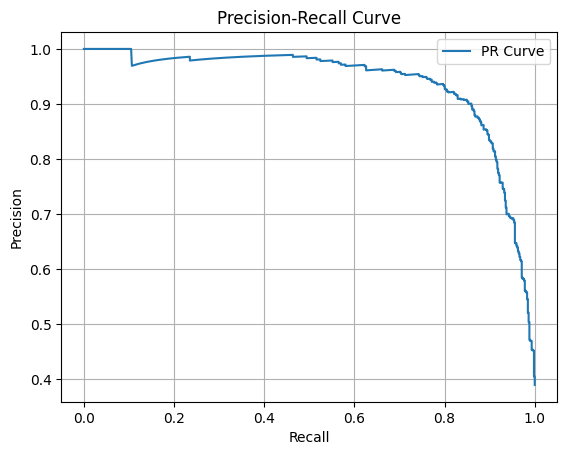

In [13]:
# PR curve
combined_model.plot_pr_curve(test_labels, test_probabilities)
# Plot t-SNE for the best model

embedding来啦 (1536,)


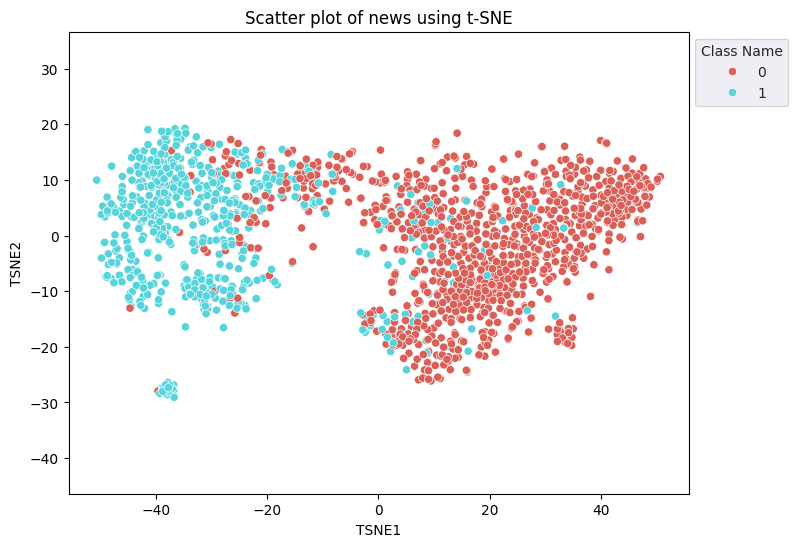

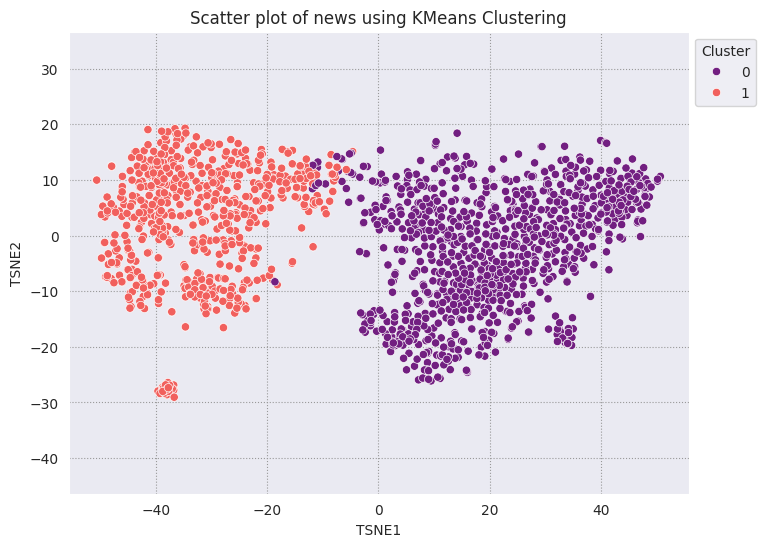

In [14]:
# cluster to show the quality of embeddings
combined_model.plot_tsne(test_embeddings, test_labels)

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix on Dataset I', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    plt.tight_layout()

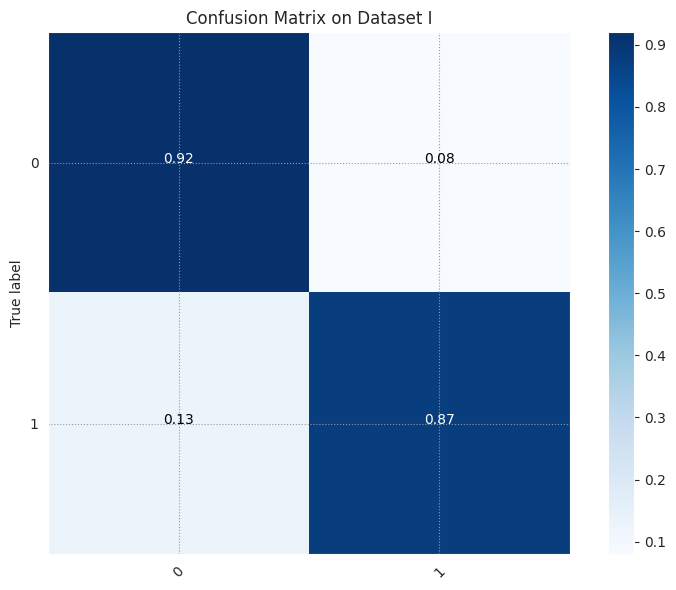

In [17]:
cm = confusion_matrix(test_labels, test_predictions)

# Call the function to plot the confusion matrix
class_names = test['label'].unique()  # Replace with your class names
plot_confusion_matrix(cm, classes=class_names, normalize=True)  # Set normalize=False if you want counts instead of percentages
plt.savefig('Confusion Matrix on Dataset Patch_DB')

In [18]:
res.to_csv('combined_model_I.csv')

In [19]:
res_mis = test.copy()

In [20]:
# test_data

In [21]:
# 设置数据缺失的情况
# 设置随机种子以便结果可重复
import numpy as np
def data_missing(df):
    
    np.random.seed(42)
    
    # 定义缺失值的比例
    missing_rate = 0.2
    
    # 计算每列需要创建缺失值的数量
    num_missing = int(missing_rate * len(df))
    
    # 随机选择行进行缺失
    for col in ['message', 'diff']:
        missing_indices = np.random.choice(df.index, num_missing, replace=False)
        
        # 选择每个单元格的部分字符来替换，而不是全部替换成NaN
        for idx in missing_indices:
            if np.random.rand() > 0.5:
                # 保留前半部分
                try:
                    # print(df.loc[idx, col][:len(df.loc[idx, col])//2] + '...')
                    df.loc[idx, col] = df.loc[idx, col][:len(df.loc[idx, col])//2] + '...'
                except:
                    continue
            else:
                # 保留后半部分
                try:
                    # print('...' + df.loc[idx, col][len(df.loc[idx, col])//2:])
                    df.loc[idx, col] = '...' + df.loc[idx, col][len(df.loc[idx, col])//2:]
                except:
                    continue
    
    return df
test_data_miss = data_missing(test)

In [22]:
test_data_miss

,index,Unnamed: 0,label,message,diff
0,0,7762,0,Merge pull request #90 from hlef/master\n\nFix...,diff --git a/NEWS b/NEWS\nindex 812291ff..ea51...
1,1,7566,0,[ZEPPELIN-5190] flink-1.12-shims CollectStream...,diff --git a/flink/flink1.12-shims/src/main/ja...
2,2,7606,0,Remode UNIXODBC_SOURCE from unixodbc_conf.h,... {\n int ret = LOG_NO_DATA;\n \ndiff --...
3,3,5272,0,Explicitly enable utf8 on jdbc connection url\...,diff --git a/templates/gerrit.config.erb b/tem...
4,4,7537,1,Merge pull request #18 from g-sato/fix_securit...,"...(trim($pagetitle) ? ""$sitename - $pagetitle..."
...,...,...,...,...,...
1512,1512,6112,0,updates: Use PF4 progress...,diff --git a/pkg/apps/utils.jsx b/pkg/apps/uti...
1513,1513,274,1,error log and xss and some minor improvents\n\...,diff --git a/admin/class-user-login-history-us...
1514,1514,480,1,avformat/rmdec: Fix DoS due to lack of eof che...,diff --git a/libavformat/rmdec.c b/libavformat...
1515,1515,5688,1,Add side-channel countermeasures to DSA.\n\nTh...,diff --git a/lib/Crypto/PublicKey/DSA.py b/lib...


In [ ]:
test_data_miss['message']

0       Merge pull request #90 from hlef/master\n\nFix...
1       [ZEPPELIN-5190] flink-1.12-shims CollectStream...
2             Remode UNIXODBC_SOURCE from unixodbc_conf.h
3       Explicitly enable utf8 on jdbc connection url\...
4       Merge pull request #18 from g-sato/fix_securit...
                              ...                        
1512                         updates: Use PF4 progress...
1513    error log and xss and some minor improvents\n\...
1514    avformat/rmdec: Fix DoS due to lack of eof che...
1515    Add side-channel countermeasures to DSA.\n\nTh...
1516                      Fix VS attribute size handling.
Name: message, Length: 1517, dtype: object

In [ ]:
test_data_miss[test_data_miss['message'].str.contains('...')]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
# test_data_miss.reset_index(inplace=True)
test_miss_dataset = preprocesser.SentencePairDataset(test_data_miss, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
test_miss_loader = DataLoader(test_miss_dataset, batch_size=32, shuffle=False)
test_miss_loader

In [ ]:
test_miss_acc, test_miss_labels, test_miss_probabilities, test_miss_embeddings, test_miss_predictions = combined_model.evaluate(test_miss_loader)

In [ ]:
res_mis['test_miss_labels'] = test_miss_labels
res_mis['test_miss_probabilities'] = test_miss_probabilities
res_mis['test_miss_embeddings'] = test_miss_embeddings
res_mis['test_miss_predictions'] = test_miss_predictions

In [ ]:
res_mis.to_csv('combined_model_res_data_missing_I.csv')